In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)


In [45]:
df = pd.read_csv('Assessment 2 - MMM Weekly.csv')
df['week'] = pd.to_datetime(df['week'])
df = df.sort_values('week').reset_index(drop=True)

print(f"Data: {len(df)} weeks from {df['week'].min().strftime('%Y-%m-%d')} to {df['week'].max().strftime('%Y-%m-%d')}")
print(f"Revenue: ${df['revenue'].sum():,.0f}")
print(f"Marketing spend: ${df[['facebook_spend', 'google_spend', 'tiktok_spend', 'snapchat_spend']].sum().sum():,.0f}")


Data: 104 weeks from 2023-09-17 to 2025-09-07
Revenue: $5,101,610
Marketing spend: $893,700


# Stage 1: Google Spend Prediction


In [46]:
X_stage1 = df[['facebook_spend', 'tiktok_spend', 'snapchat_spend', 'promotions']].copy()
y_stage1 = df['google_spend'].copy()

scaler1 = StandardScaler()
X_stage1_scaled = scaler1.fit_transform(X_stage1)

tscv = TimeSeriesSplit(n_splits=5, test_size=20, gap=0)
xgb_stage1 = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=8,
    tree_method='hist'
)

param_grid1 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

grid1 = GridSearchCV(
    xgb_stage1,
    param_grid1,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=8
)


In [47]:
grid1.fit(X_stage1_scaled, y_stage1)
best_stage1 = grid1.best_estimator_

print(f"Stage 1 - CV Score: {grid1.best_score_:.4f}")
print(f"Best params: {grid1.best_params_}")

feature_importance1 = pd.DataFrame({
    'feature': X_stage1.columns,
    'importance': best_stage1.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance (Google Spend):")
for _, row in feature_importance1.iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")


Stage 1 - CV Score: -2143.2417
Best params: {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1.5}

Feature importance (Google Spend):
  promotions: 0.504
  snapchat_spend: 0.172
  facebook_spend: 0.164
  tiktok_spend: 0.160



Stage 1 Results:
R²: 0.943 | RMSE: $441
Actual: $160,562 | Predicted: $159,196 | Error: -0.9%


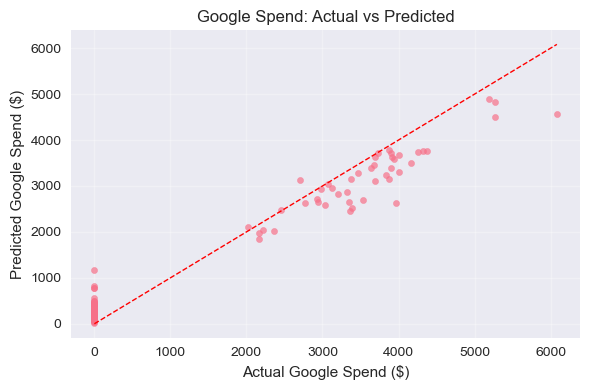

In [48]:
df['Google_pred'] = best_stage1.predict(X_stage1_scaled)

r2_stage1 = r2_score(y_stage1, df['Google_pred'])
rmse_stage1 = root_mean_squared_error(y_stage1, df['Google_pred'])

actual_total = df['google_spend'].sum()
predicted_total = df['Google_pred'].sum()
prediction_error = ((predicted_total - actual_total) / actual_total) * 100

print(f"\nStage 1 Results:")
print(f"R²: {r2_stage1:.3f} | RMSE: ${rmse_stage1:,.0f}")
print(f"Actual: ${actual_total:,.0f} | Predicted: ${predicted_total:,.0f} | Error: {prediction_error:+.1f}%")

plt.figure(figsize=(6, 4))
plt.scatter(df['google_spend'], df['Google_pred'], alpha=0.7, s=20)
plt.plot([0, df['google_spend'].max()], [0, df['google_spend'].max()], 'r--', lw=1)
plt.xlabel('Actual Google Spend ($)')
plt.ylabel('Predicted Google Spend ($)')
plt.title('Google Spend: Actual vs Predicted')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Stage 2: Revenue Impact Modeling



In [52]:
X_stage2 = df[['Google_pred', 'emails_send', 'sms_send', 'average_price', 'promotions', 'social_followers']].copy()
y_stage2 = df['revenue'].copy()

scaler2 = StandardScaler()
X_stage2_scaled = scaler2.fit_transform(X_stage2)

xgb_stage2 = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=8,
    tree_method='hist'
)

param_grid2 = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.15],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 1.5]
}

grid2 = GridSearchCV(
    xgb_stage2,
    param_grid2,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=8
)


In [53]:
grid2.fit(X_stage2_scaled, y_stage2)
best_stage2 = grid2.best_estimator_

print(f"Stage 2 - CV Score: {grid2.best_score_:.4f}")
print(f"Best params: {grid2.best_params_}")

feature_importance2 = pd.DataFrame({
    'feature': X_stage2.columns,
    'importance': best_stage2.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance (Revenue):")
for _, row in feature_importance2.iterrows():
    print(f"  {row['feature']}: {row['importance']:.3f}")

correlations = X_stage2.corrwith(y_stage2).sort_values(ascending=False)
print("\nCorrelations with Revenue:")
for feature, corr in correlations.items():
    print(f"  {feature}: {corr:.3f}")


Stage 2 - CV Score: -99316.8222
Best params: {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 1}

Feature importance (Revenue):
  sms_send: 0.381
  social_followers: 0.308
  emails_send: 0.103
  Google_pred: 0.082
  average_price: 0.067
  promotions: 0.059

Correlations with Revenue:
  sms_send: 0.380
  social_followers: 0.043
  emails_send: 0.033
  Google_pred: -0.034
  promotions: -0.189
  average_price: -0.295



Stage 2 Results:
R²: 0.944 | RMSE: $22,054
Actual: $5,101,610 | Predicted: $5,023,616 | Error: -1.5%
ROI: 5.71x | Marketing Spend: $893,700

Results saved: mmmdataset_predicted.csv


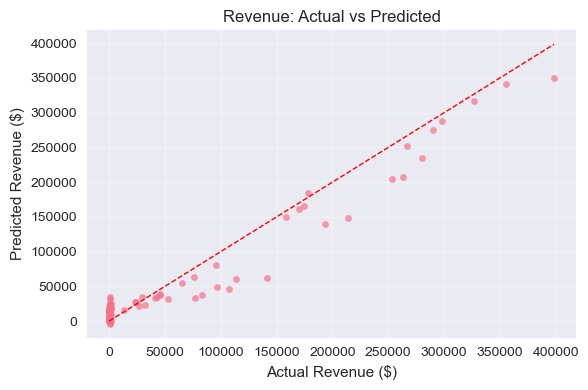

In [54]:
df['Revenue_pred'] = best_stage2.predict(X_stage2_scaled)

r2_stage2 = r2_score(y_stage2, df['Revenue_pred'])
rmse_stage2 = root_mean_squared_error(y_stage2, df['Revenue_pred'])

actual_revenue = df['revenue'].sum()
predicted_revenue = df['Revenue_pred'].sum()
revenue_error = ((predicted_revenue - actual_revenue) / actual_revenue) * 100

total_spend = df[['facebook_spend', 'google_spend', 'tiktok_spend', 'snapchat_spend']].sum().sum()
roi = actual_revenue / total_spend if total_spend > 0 else 0

print(f"\nStage 2 Results:")
print(f"R²: {r2_stage2:.3f} | RMSE: ${rmse_stage2:,.0f}")
print(f"Actual: ${actual_revenue:,.0f} | Predicted: ${predicted_revenue:,.0f} | Error: {revenue_error:+.1f}%")
print(f"ROI: {roi:.2f}x | Marketing Spend: ${total_spend:,.0f}")

df.to_csv('mmmdataset_predicted.csv', index=False)
print(f"\nResults saved: mmmdataset_predicted.csv")

plt.figure(figsize=(6, 4))
plt.scatter(df['revenue'], df['Revenue_pred'], alpha=0.7, s=20)
plt.plot([0, df['revenue'].max()], [0, df['revenue'].max()], 'r--', lw=1)
plt.xlabel('Actual Revenue ($)')
plt.ylabel('Predicted Revenue ($)')
plt.title('Revenue: Actual vs Predicted')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
